In [1]:
from mpi4py import MPI
from dolfinx import mesh
import numpy

# Create mesh
domain = mesh.create_unit_square(MPI.COMM_WORLD, 8, 8, mesh.CellType.quadrilateral)

In [2]:
# Define function space
from dolfinx import fem
V = fem.functionspace(domain, ("Lagrange", 1))


In [3]:
# Define Dirichlet boundary condition
uD = fem.Function(V)
uD.interpolate(lambda x: 1 + x[0]**2 + 2 * x[1]**2)


In [4]:
# Define boundary condition
tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)
boundary_facets = mesh.exterior_facet_indices(domain.topology)

In [9]:
# Define trial and test functions
import ufl
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

In [10]:
# Locate boundary dofs
boundary_dofs = fem.locate_dofs_topological(V, fdim, boundary_facets)
bc= fem.dirichletbc(uD, boundary_dofs)

In [19]:
# Corrected code for recent DOLFINx versions:
from dolfinx import default_scalar_type 
f=fem.Constant(domain, default_scalar_type(-6))

In [20]:
# Define variational problem
a = ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = f * v * ufl.dx

In [22]:
from dolfinx.fem.petsc import LinearProblem

problem = LinearProblem(
    a,
    L,
    bcs=[bc],
    petsc_options={"ksp_type": "preonly", "pc_type": "lu"},
    petsc_options_prefix="Poisson",
)
uh = problem.solve()

In [23]:
# Compute error
V2 = fem.functionspace(domain, ("Lagrange", 2))
uex = fem.Function(V2)
uex.interpolate(lambda x: 1 + x[0]**2 + 2 * x[1]**2)

L2_error = fem.form(ufl.inner(uh - uex, uh - uex) * ufl.dx)
error_local = fem.assemble_scalar(L2_error)
error_L2 = numpy.sqrt(domain.comm.allreduce(error_local, op=MPI.SUM))

In [25]:
error_max = numpy.max(numpy.abs(uD.x.array - uh.x.array))
if domain.comm.rank == 0:  # Only print the error on one process
    print(f"Error_L2 : {error_L2:.2e}")
    print(f"Error_max : {error_max:.2e}")

Error_L2 : 8.24e-03
Error_max : 3.55e-15


In [26]:
import pyvista
print(pyvista.global_theme.jupyter_backend)

trame


In [27]:
from dolfinx import plot
domain.topology.create_connectivity(0, tdim)
topology, cell_types, geometry = plot.vtk_mesh(domain, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

/home/shienwei/miniconda3/envs/fenicsx-env/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


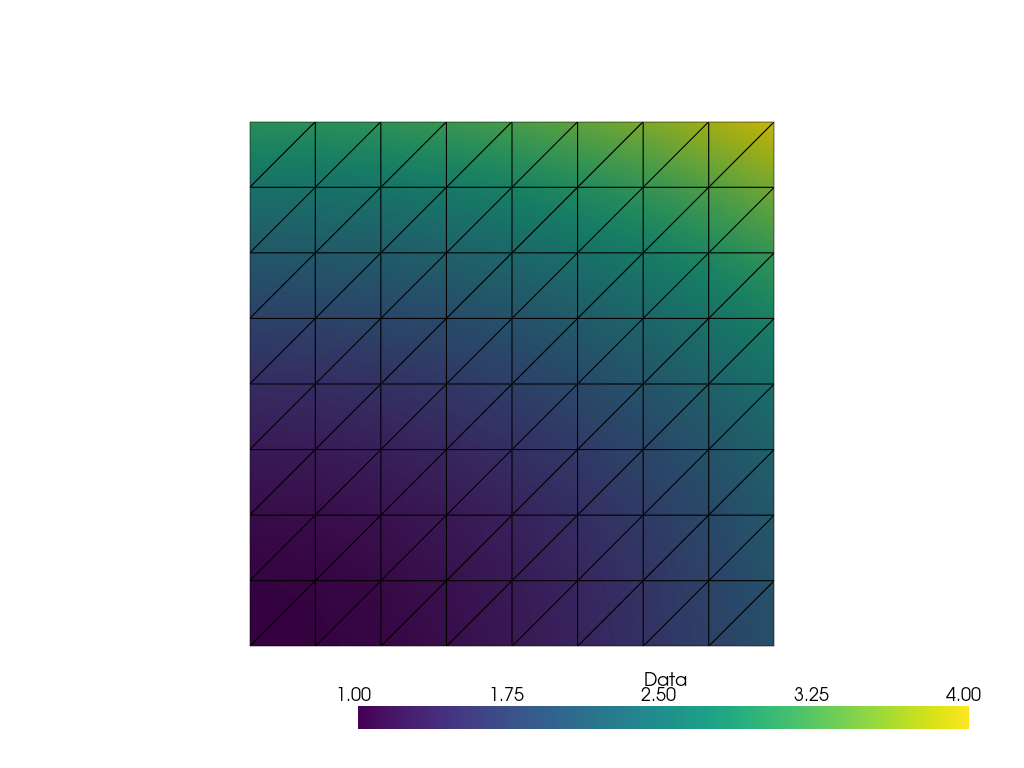

In [31]:
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("fundamentals_mesh.png")

/home/shienwei/miniconda3/envs/fenicsx-env/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


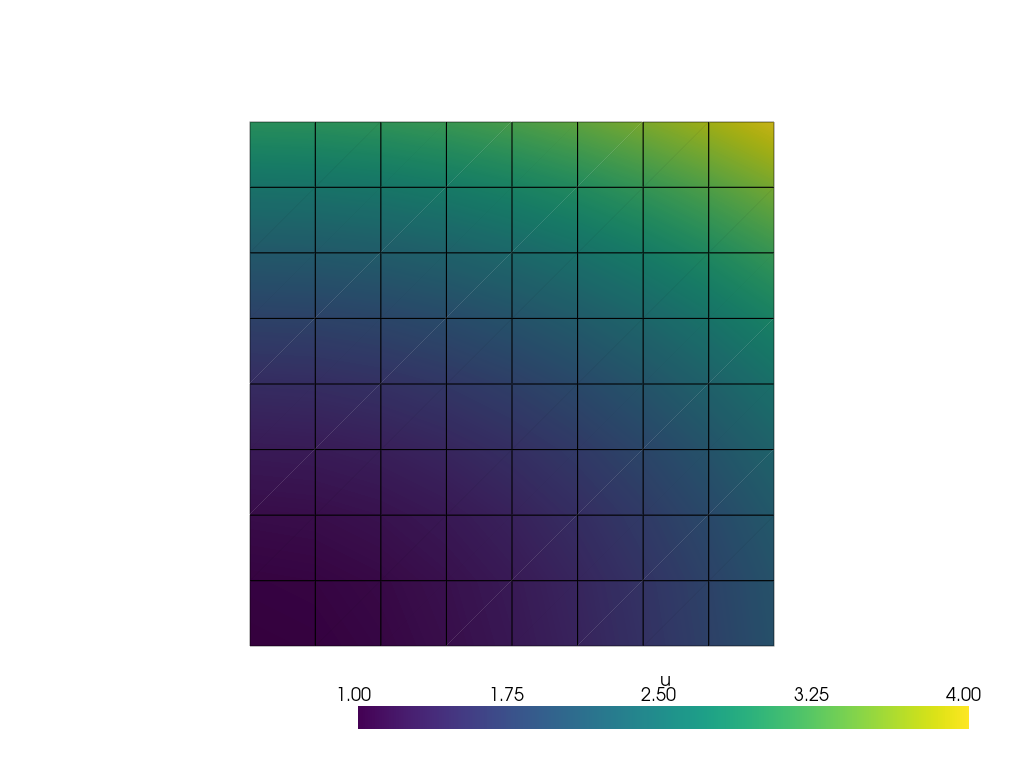

In [32]:
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = uh.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()

/home/shienwei/miniconda3/envs/fenicsx-env/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


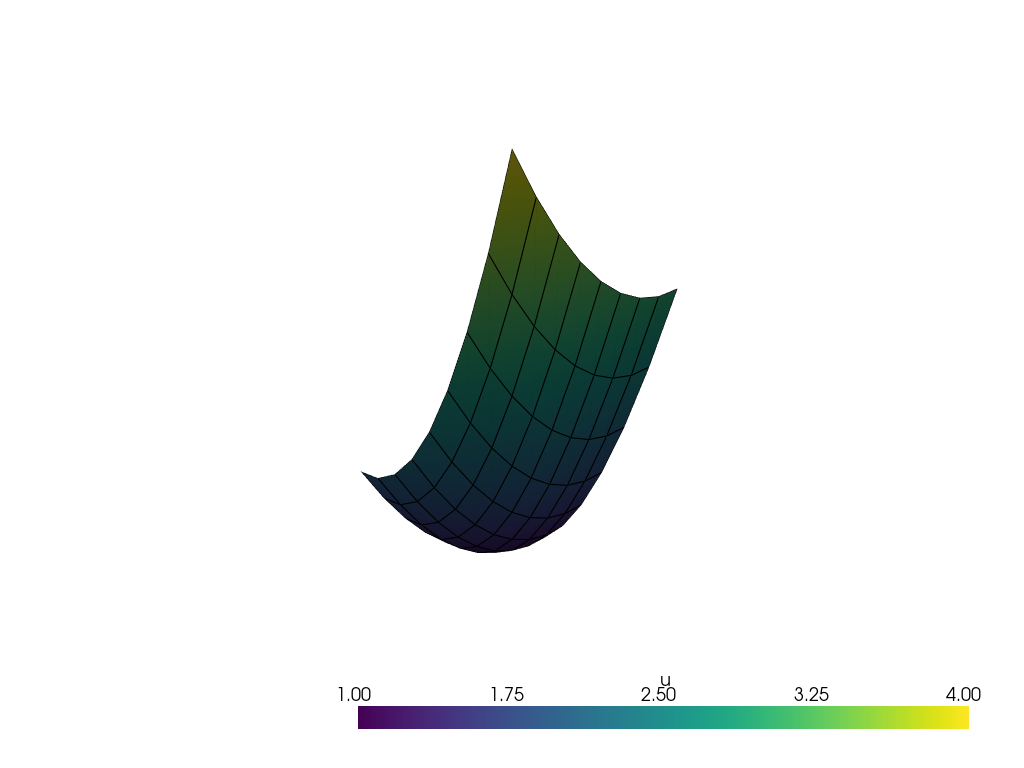

In [33]:
warped = u_grid.warp_by_scalar()
plotter2 = pyvista.Plotter()
plotter2.add_mesh(warped, show_edges=True, show_scalar_bar=True)
if not pyvista.OFF_SCREEN:
    plotter2.show()